ValueError: x and y must be the same size

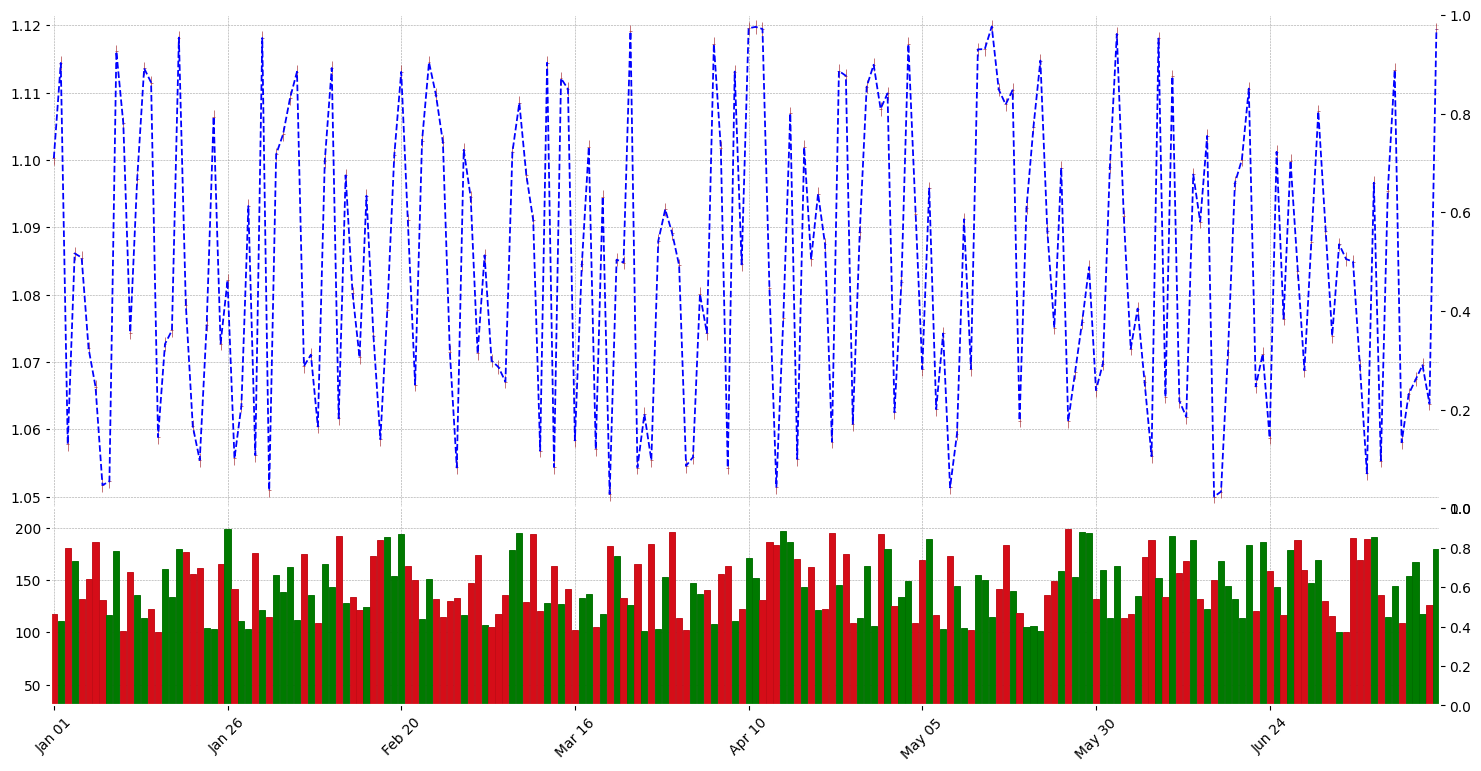

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from datetime import datetime

# Configuración de los logs
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

class BaseStrategy:
    def __init__(self):
        pass

    def execute_trade(self, signal):
        raise NotImplementedError("Este método debe ser implementado por estrategias específicas.")

    def get_signal(self, market_data):
        raise NotImplementedError("Este método debe ser implementado por estrategias específicas.")

class ThresholdStrategy(BaseStrategy):
    def __init__(self, buy_threshold=1.09451, sell_threshold=1.10):
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold

    def get_signal(self, market_data):
        market_data['signal'] = 0
        market_data['buy_signal'] = (market_data['close'] > self.buy_threshold).astype(int)
        market_data['sell_signal'] = (market_data['close'] >= self.sell_threshold).astype(int)
        return market_data

    def execute_trade(self, signal):
        if signal == 1:
            print("Ejecutar compra")
        elif signal == -1:
            print("Ejecutar venta")
        else:
            print("Mantener posición")

def load_and_process_data(file_path, chunksize=100000):
    try:
        logger.info(f"Cargando y procesando datos desde {file_path} en bloques de {chunksize} filas...")

        # DataFrame final para almacenar los resultados procesados
        all_data = pd.DataFrame()
        error_count = 0  # Contador de filas con errores

        # Leer el archivo CSV en bloques
        for chunk in pd.read_csv(
            file_path,
            header=0,  # Asumimos que el archivo CSV tiene encabezados
            names=["DateTime", "Bid", "Ask", "Volume"],
            dtype={"DateTime": str, "Bid": float, "Ask": float, "Volume": int},  # Especificar tipos de datos
            chunksize=chunksize,
            low_memory=False
        ):
            logger.info("Procesando un nuevo bloque...")

            # Convertir la columna 'DateTime' a tipo datetime
            chunk['DateTime'] = pd.to_datetime(chunk['DateTime'], format='%Y%m%d %H:%M:%S.%f', errors='coerce')

            # Filtrar filas con valores inválidos o NaN
            chunk = chunk.dropna()

            # Concatenar el bloque procesado al DataFrame final
            all_data = pd.concat([all_data, chunk], ignore_index=True)

        # Configurar la columna 'DateTime' como índice
        all_data.set_index('DateTime', inplace=True)

        logger.info("Datos cargados y procesados correctamente.")
        logger.info(f"Total de filas con errores: {error_count}")
        return all_data

    except Exception as e:
        logger.error(f"Error al procesar los datos: {e}")
        return None

def test_strategy(strategy, market_data):
    signals = strategy.get_signal(market_data)

    # Mostrar todas las veces que se hubiese activado la compra
    buy_signals = signals[signals['buy_signal'] == 1]
    print("Señales de compra activadas:")
    print(buy_signals)

    # Visualizar los datos y las señales
    plt.figure(figsize=(12, 6))
    plt.plot(market_data.index, market_data['close'], label='Close Price')
    plt.plot(buy_signals.index, buy_signals['close'], 'g^', markersize=10, label='Buy Signal')
    plt.axhline(y=strategy.buy_threshold, color='blue', linestyle='--', label='Buy Threshold')
    plt.axhline(y=strategy.sell_threshold, color='red', linestyle='--', label='Sell Threshold')
    plt.legend()
    plt.show()

# Ruta al archivo CSV (actualiza esta ruta según tu sistema)
file_path = '/Users/daniel/Desktop/bot/trading-bot/src/data/data.csv'

# Procesar el archivo
data = load_and_process_data(file_path, chunksize=100000)

if data is not None:
    logger.info(data.info())
    print(data.head())

    # Crear una estrategia y probarla
    strategy = ThresholdStrategy()

    # Crear datos simulados para pruebas si no hay columna 'close'
    if 'close' not in data.columns:
        data['close'] = (data['Bid'] + data['Ask']) / 2

    test_strategy(strategy, data)
else:
    logger.error("No se generó ningún DataFrame procesado.")
